# How to Use This Tutorial

This notebook includes markdown cells (such as this one), which provide useful information and narration of what is happening, and code cells (such as the next one), which actually do things. To execute a code cells, click in the cell and then hit Shift+Enter. Alternatively, click within a cell and hit the Run button (play symbol). Depending on how you are running the notebook (via Google Colab or offline, and further depending on your installed version of Jupyter and/or Jupyter-lab), you may see slightly different options. The play symbol may appear in each cell, or above the cells in the toolbar.

When a cell completes executing, a number will appear (or update) on the left-hand side of the cell. You can also execute some or all of the cells via options in the 'Runtime' menu, above.  Again, depending on how you are running this notebook you may have either a 'Run' or 'Runtime' menu, but both will have similar options for executing chunks of the code.

**Important**: Note that some of the code blocks include exercises, with incomplete code, so you can't just run the whole notebook. You are strongly encouraged to go through the blocks one by one, in the order given.  Exercises do not need to be fully completed before proceeding to the next block.

## Google Colab Setup
If executing this notebook in Google Colab, there are some preliminary steps required before you start.

1. First open the notebook SSWYieldModelingTutorial1_colab_Setup.ipynb and execute its contents
2. Open the copy of this Notebook that has been copied into the Colab environment and execute the next 5 cells in sequence
3. Proceed with the rest of the tutorial

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# SSW Yield Modeling Tutorial
YMT_dir = 'SSW2024/SSWYieldModelingTutorial' #@param {type:"string"}

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# Create the YMT_dir directory in drive
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# YMT_dir directory path
YMT_path = os.path.join(drive_dir, YMT_dir)

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# Change to the YMT_path
os.chdir(YMT_path)

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
# Install the tutorial backend and requirements - this can also take a little while
!pip install -e .

## Tutorial Setup

In [3]:
# This is the start of the tutorial.  All users should execute all cells starting with this one
# import all required modules
import numpy as np
import astropy.units as u
from sympy import symbols, cos, sin, Matrix, simplify, sqrt
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
from matplotlib import ticker
import scipy

In [2]:
# this is temporary debugging code and will be removed
import importlib
import SSWYieldModelingTutorial.SSWYieldModelingTutorial
importlib.reload(SSWYieldModelingTutorial.SSWYieldModelingTutorial)
from SSWYieldModelingTutorial import SSWYieldModelingTutorial

In [3]:
# set up plotting
%matplotlib widget
plt.rcParams.update({'figure.max_open_warning': 0})

# Learning Outcomes

This tutorial is intended to introduce the key concepts in science yield modeling for exoplanet direct imaging missions. Upon completion of the tutorial you will be able to:

1. Compute the quantities measured by exoplanet imaging instrument
2. Estimate the probability of exoplanet detection by an imaging instrument
3. Evaluate the impacts of instrument and astrophysical noise sources on exoplanet imaging observations
4. Construct basic imaging campaign schedules
5. Evaluate the impacts of target availability and other constraints on exoplanet mission yield

# The Direct Imaging Observables

## Derivation of the Governing Equations
We wish to compute the direct imaging observable parameters over the course of a planet's orbit.  Typically, we parametrize these observables as the projected separation between star and planet ($s$) and the difference in brightness between planet and star (their flux ratio on a magnitude scale, which we call $\Delta\mathrm{mag}$. 

A two-body (Keplerian) orbit is typically encoded via 6 variables: The semi-major axis ($a$) and eccentricity ($e$) which define the shape of the conic section of the orbit (in our case, all orbits will be elliptical or circular). The orbit's orientation in 3-dimensional space is encoded via three Euler angles: the argument of periapsis ($\omega$), the inclination ($I$), and the longitude of the ascending node ($\Omega$). Finally, in order to map time on the orbit to absolute time, we need to define the time of periapsis passage (closest approach between the planet and its host star: $t_p$). The planet's progress along its orbit can then be tracked via time, or any one of several anomaly angles, such as the true anomaly ($\nu$). From these parameters, we can define the planet's orbital radius magnitude as:
$$r = \frac{a(1 - e^2)}{1 + e\cos(\nu)}$$

![title](../img/exoplanet_orbit_diagram_annotated.png)

Let's get Python to produce equations for these starting from first principles.

In [4]:
# define required symbols and the rotation matrices for the orbit's rotation
r,I,O,w,nu,th = symbols("r,I,Omega,omega,nu,theta",real=True, positive=True)
rot1 = Matrix(([cos(O), sin(O), 0], [-sin(O), cos(O), 0], [0, 0, 1]))
rot2 = Matrix(([1, 0, 0], [0, cos(I), sin(I)], [0, -sin(I), cos(I)]))
rot3 = Matrix(([cos(w), sin(w), 0], [-sin(w), cos(w), 0], [0, 0, 1]))
pCi = rot3*rot2*rot1 # this is the rotation of the perifocal frame in the inertial frame
iCp = pCi.transpose() # this is the rotation of the inertial frame in the perifocal frame

# we can now define the orbital radius vector in the frame where the observer
# is located along the negative third axis
r_p = Matrix([r*cos(nu),r*sin(nu),0])
r_i = simplify(iCp*r_p)
r_i

Matrix([
[r*(-sin(Omega)*sin(nu + omega)*cos(I) + cos(Omega)*cos(nu + omega))],
[ r*(sin(Omega)*cos(nu + omega) + sin(nu + omega)*cos(I)*cos(Omega))],
[                                           r*sin(I)*sin(nu + omega)]])

We can simplify things a bit by defining the argument of latitude $\theta \triangleq \nu+\omega$:

In [5]:
r_i = r_i.subs(nu+w, th)
r_i

Matrix([
[r*(-sin(Omega)*sin(theta)*cos(I) + cos(Omega)*cos(theta))],
[ r*(sin(Omega)*cos(theta) + sin(theta)*cos(I)*cos(Omega))],
[                                      r*sin(I)*sin(theta)]])

We can now find an expression for the projected separation from the first two components of our orbital radius vector:

In [6]:
s = simplify(sqrt(r_i[0]**2 + r_i[1]**2))
s

r*sqrt(-sin(I)**2*sin(theta)**2 + 1)

The $\Delta\mathrm{mag}$ is a bit more complicated: 
$$ \Delta{\textrm{mag}} \triangleq -2.5\log_{10}\left(\frac{F_P}{F_S}\right) =  -2.5\log_{10}\left(p\Phi(\beta) \left(\frac{R_P}{r}\right)^2 \right)$$
where $p$ is the geometric albedo of the planet (the fraction of light reflected/scattered by the planet), $R_P$ is the planet's radius, and $Phi(\beta)$ is the planet's phase function (how the fraction of reflected light changes with the planet's phase angle $\beta$).  The phase angle is the star-planet-observer angle, and can be approximated as:
$$ \cos\beta \approx \sin I \sin\theta$$

Note that we can calculate both $s$ and $\Delta\mathrm{mag}$ with only a subset of our orbital elements and planetary parameters.  All that we need is $a, e, \nu, \omega, I, R_P$.

Real planets can have very complex phase functions, based on many parameters whose distributions are not yet well known.  Instead of modeling all of this complexity, we frequently just use the Lambert phase function, which describes an isotropic scatterer (one that reflects light equally in all directions):

$$\pi\Phi_L(\beta) = \sin\beta + (\pi - \beta)\cos\beta$$

Let's now simulate the observable values over the course of one orbit. We'll define some parameters that are vaguely Earth-like:

In [7]:
# define the orbital elements. Note the use of astropy units to keep things consistent
a = 1*u.AU #semi-major axis = 1 AU
e = 0.2 # this is actually a pretty high eccentricity
I = 90*u.deg # 90 degree inclination - edge-on orbit
w = 15*u.deg # 15 degree argument of periapsis
R_P = 1*u.earthRad # Earth radius-equivalent planet
p = 0.367 # geometric albedo
nu = np.linspace(0,2*np.pi,100)*u.rad # The true anomaly varies between 0 and 2\pi over the course of the orbit

## Exercise 1
Now it's your turn.  Write code to use the variables defined in the previous block to compute the projected separation and $\Delta\mathrm{mag}$ over the course of the orbit.

In [ ]:
# compute the observables
# Note that these are numerical computations on arrays, so you should be using numpy
# methods, such as np.cos, np.sin, np.sqrt, etc.
r =       # compute the oribtal radius
theta =   # compute the argument of latitude
s =       # compute the projected separation
beta =    # compute the phase angle
Phi =     # compute the value of the Lambert phase function
dMag =    # compute the Delta mag

# if you get stuck, a reference solution is provided by:
# s, dMag = SSWYieldModelingTutorial.calc_s_dMag(a, e, I, w, R_P, p, nu)

Now that we have some values, let's plot them:

In [ ]:
# let's plot some values 
fig1, ax1a = plt.subplots()

color1 = 'tab:red'
ax1a.set_xlabel(f'True Anomaly ({nu.unit})')
ax1a.set_ylabel(f'Projected Separation ({s.unit})', color=color1)
ax1a.plot(nu, s, color=color1)
ax1a.tick_params(axis='y', labelcolor=color1)
ax1a.set_xlim([0,2*np.pi])

ax1b = ax1a.twinx() 
color2 = 'tab:blue'
ax1b.set_ylabel('$\Delta$mag', color=color2) 
ax1b.plot(nu, dMag, color=color2)
ax1b.tick_params(axis='y', labelcolor=color2)

Remember: the point of computing these values is to check whether or not a planet is visible at a given time.  The simplest way to do so is to define limits on observable projected separations and $\Delta\mathrm{mag}$ values.  For projected separation, this actually maps quite well to how starlight-suppression systems work.  Essentially all such systems have an inner working angle (IWA) and outer working angle (OWA).  If expressed in units of arcseconds, these values map directly to minimum and maximum observable projected separations (in AU) when multiplied by the distance to the target (in parsecs).  For $\Delta\mathrm{mag}$, as we will presently see, setting limits is a bit more complicated, so for now, we will just say that we can pick a constant $\Delta\mathrm{mag}$ limit. 

Let's define some limits and see how these limits interact with our plot:

In [ ]:
IWA = 0.075 #arcseconds
OWA = 2 #arcseconds
d = 10  #distane to star in parsecs
dMaglim = 25 #we have a constant limiting delta magnitude 

## Exercise 2
Using the previously computed values of $s$ and $\Delta\mathrm{mag}$, along with the limits defined in the previous block, compute a boolean array of values (of the same size as `s` and `dMag`) that is True where the planet is observable and false otherwise:

In [ ]:
# You are being asked to compute boolean values on an array, which can be done
# with comparison operators such as >, >=, ==, etc.  Arrays of boolean values
# can also be ANDed or ORed as (bool arr 1) & (bool arr 2) and 
# (bool arr 1) | (bool arr 2), respectively

observable_indices =

# if you get stuck, a reference solution is provided by:
# observable_indices = SSWYieldModelingTutorial.observable_indices(s, dMag, d, IWA, OWA, dMaglim)

In [ ]:
# let's update our plot with the observable regions highlighted
# the planet is obserable under our stated constraints (dashed lines)
# on the thicker portions of the plots

# this is just used to split the observable indices into contiguous blocks for plotting:
sepinds = SSWYieldModelingTutorial.split_observable_inds(observable_indices)

for inds in sepinds:
    ax1a.plot(nu[inds], s[inds],color=color1, linewidth=4)
ax1a.plot([0,2*np.pi], [IWA*d]*2, '--', color=color1)

for inds in sepinds:
    ax1b.plot(nu[inds], dMag[inds],color=color2, linewidth=4)
ax1b.plot([0,2*np.pi], [dMaglim]*2, '--', color=color2)

# scroll up to see the updates on your original plot

## The Impact of Orbital Inclination

Of all of the input parameters, the one that has the largest impact on these values is the inclination (why?).  Let's see how the curves change as we change the orbital inclination. Note that this is also a chance to check your results from the first two exercises. 

interactive(children=(IntSlider(value=50, description='j'), Output()), _dom_classes=('widget-interact',))

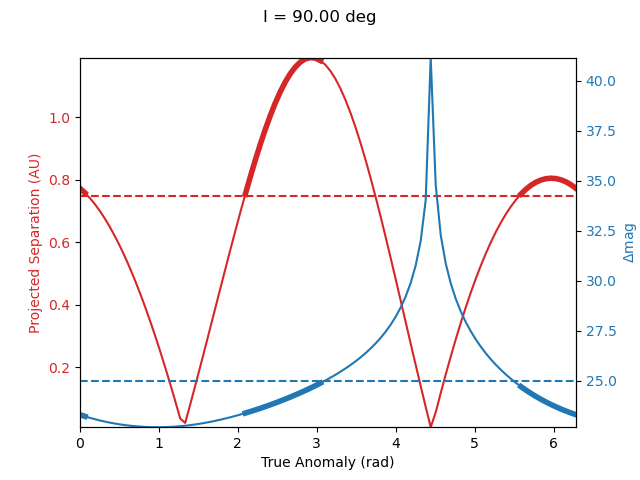

In [8]:
# We're going to now compute s and dMag on a grid of I and nu values
I0 = np.linspace(0,np.pi,101)*u.rad # full range of possible integrations
nu0 = np.linspace(0,2*np.pi,100)*u.rad # The true anomaly varies between 0 and 2\pi over the course of the orbit
[Is, nus] = np.meshgrid(I0,nu0)

ss, dMags = SSWYieldModelingTutorial.calc_s_dMag(1*u.AU, 0.2, Is, 15*u.deg,  1*u.earthRad, 0.367, nus)
ss = ss.transpose()
dMags = dMags.transpose()

# same constraints as before:
IWA = 0.075 #arcseconds
OWA = 2 #arcseconds
d = 10  #distane to star in parsecs
dMaglim = 25 #we have a constant limiting delta magnitude 

fig2, ax2a = plt.subplots()

color1 = 'tab:red'
ax2a.set_xlabel(f'True Anomaly ({nu0.unit})')
ax2a.set_ylabel(f'Projected Separation ({ss.unit})', color=color1)
scurve = ax2a.plot(nu0, ss[0], color=color1)[0]
ax2a.tick_params(axis='y', labelcolor=color1)
ax2a.set_xlim([0,2*np.pi])
ax2a.plot([0,2*np.pi], [IWA*d]*2, '--', color=color1)

ax2b = ax2a.twinx() 
color2 = 'tab:blue'
ax2b.set_ylabel('$\Delta$mag', color=color2) 
dMagcurve = ax2b.plot(nu0, dMags[0], color=color2)[0]
ax2b.tick_params(axis='y', labelcolor=color2)
ax2b.plot([0,2*np.pi], [dMaglim]*2, '--', color=color2)

fig2.suptitle(f"I = {I0[0].to(u.deg) :.2f}")
overlines = []

def drawInclinationFrame(j):
    scurve.set_data(nu0, ss[j])
    dMagcurve.set_data(nu0, dMags[j])
    fig2.suptitle(f"I = {I0[j].to(u.deg):.2f}")
    ax2a.set_ylim([ss[j].value.min(), ss[j].value.max()])
    ax2b.set_ylim([dMags[j].min(), dMags[j].max()])
    obsinds = SSWYieldModelingTutorial.observable_indices(ss[j], dMags[j], d, IWA, OWA, dMaglim)
    sepinds = SSWYieldModelingTutorial.split_observable_inds(obsinds)
    while len(overlines) > 0:
        overlines.pop().remove()
    for inds in sepinds:
        overlines.append(ax2a.plot(nu0[inds], ss[j][inds],color=color1, linewidth=4)[0])
    for inds in sepinds:
        overlines.append(ax2b.plot(nu0[inds], dMags[j][inds],color=color2, linewidth=4)[0])

widgets.interact(drawInclinationFrame, j=widgets.IntSlider(min=0, max=len(I0)-1, step=1, value=50));
# use slider to change the orbit inclination

A key aspect of what we're seeing here is that orbital inclination places a limit on the range of observable face angle.  A face-on orbit (one with a 0$^\circ$ inclination) will always be viewed at a 90$^\circ$ phase (known as **quadrature**). Only an edge-on orbit (one with 90$^\circ$) inclination will actually pass through the full range of $\beta$ values (0 to 180$^\circ$).  For intermediate values of inclination, the planet phase will always be in the range $[90^\circ - I, 90^\circ + I]$.

Another very important thing to note is the range of projected separations.  If you look back to the orbital radius magnitude equation, you'll note that the orbital radius ranges between $a(1-e)$ and $a(1+e)$.  The projected separation will always be less than or equal to the orbital radius (we can see this by inspection of the equation we derived, above). This means that when the projected separation is smaller than the semi-major axis, this is due to either the orbital eccentricity or projection effects (e.g., when the orbit is anything other than face-on).  When the projected separation is greater than the semi-major axis, this is due *only* to eccentricity.  A cool result that you can prove from all of this is that, given a single observation of a planet, the observed projected separation is actually the maximum likelihood estimate of its semi-major axis. 

# The Direct Imaging Observable Joint Probability Density Function

Now that we have the ability to compute the imaging observables, we can proceed to compute the joint probability density function of these values for a given population of planets. We will call this density function $f_{\Delta\mathrm{mag},s}$.

There are multiple different ways to do this calculation, but the conceptually simplest is via Monte Carlo: we will draw random samples from density functions describing all of our input parameters, and then use these to compute the corresponding projected separation and $\Delta\mathrm{mag}$ values.  We will then form a 2D histogram over these computed values, thereby estimating their joint probability density function.

An important thing to note is that, in reality, the input parameters may not be independent, and may have joint prior functions of their own.  Here, we will ignore this bit of complexity, and treat all inputs as fully independent of one another. 

We are going to try modeling a population of Earth-like planets.  Note that there is an enormous body of literature establishing various priors for this population. Here, we will make multiple simplifying assumptions.

For the semi-major axis, we will assume a uniform distribution between 0.7 and 1.5 AU (note that this assumption is non-physical - real planet orbits appear to be distributed logarithmically in semi-major axis, but this is a reasonable approximation to make when focusing on a small interval of semi-major axes. We will similarly approximate eccentricities as uniformly distributed between 0 and 0.35 (again, this is not what the actual universe appears to do). We will take all of the planets in our population to have radii of exactly 1 Earth radius, and geometric albedos of 0.367. 

Finally, we will assume that orbit orientation are isotropically distributed over the unit sphere (e.g., that there is no preferred orbital plane).  This means that both $\omega$ and $\Omega$ are uniformly distributed between 0 and $2\pi$ radians, whereas $I$ is sinusoidally distributed, e.g.:
$$f_\bar{I}(I) = \begin{cases} \dfrac{\sin(I)}{2}  & I \in [0, \pi] \\ 0 & \mathrm{else} \end{cases}$$

Finally, we are interested in sampling the populations consistently with arbitrarily timed observations.  Thus, we treat the time of observation as uniformly distributed, which corresponds to a uniform distribution in mean anomaly ($M$). This is related to the true anomaly via the Kepler time equation:
$$M = E - e\sin(E)$$
where $E$ is the eccentric anomaly, which maps to true anomaly as:
$$\tan\left(\frac{E}{2}\right) = \sqrt{\frac{1-e}{1+e}}\tan\left(\frac{\nu}{2}\right)$$

## Exercise 3
Let's generate some values and see how this all works:

In [ ]:
N = int(1e5); #number of samples to generate
# these values are constant
R_P = (1*u.earthRad).to(u.AU).value # Earth radius-equivalent planet in AU
p = 0.367 # geometric albedo

# we'll skip the units this time to make computations a bit more efficient
# Hint 1: numpy provides the very useful method np.random.uniform. See:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
#
# Hint 2: A sinusoidal distribution can be generated by taking the 
#         arccosine of a uniform distribution between -1 and 1

# generate an array of semi-major axis values
# uniformly distributed between 0.7 and 1.5 AU:
avals = 

# generate an array of eccentricity values
# uniformly distributed between 0 and 0.35
evals = 

# generate an array of argument of periapsis values
# uniformly distributed between 0 and 2\pi
wvals = 

# generate an array of inclination values 
# sinusoidally distributed between 0 and \pi
Ivals = 

# Generate an array of mean anomaly values 
# uinformly distributed between 0 and 2\pi
Mvals = 

# if you get stuck, a reference solution is provided by:
#avals, evals, wvals, Ivals, Mvals, R_P, p = SSWYieldModelingTutorial.gen_Earthlike_values(int(1e5))

Now that we have the values, we need a bit more work before we can compute our imaging observables.  In particular, note that the Kepler time equation is a transcendental function, and must be inverted numerically (typically using Newton-Raphson iteration). There are many, many software packages in the Python ecosystem that will do this for you - we will use our own implementation here, but lots of others are available to you.

Once we have the true anomaly values, we can use our previously written code to compute the corresponding projected separation and $\Delta\mathrm{mag}$ values.  We then use some helper method to compute the 2D histogram of these values (normalized by the number of samples and bin areas to make it representative of a true probability density function) and finally to plot the results.

In [ ]:
# compute true anomaly from mean anomaly and eccentricity
_,_,nuvals = SSWYieldModelingTutorial.invKepler(Mvals, evals, return_nu=True)


# set semi-major axis and eccentricity ranges:
arange, erange = [0.7, 1.5], [0, 0.35]

# compute the imaging observables
svals, dMagvals = SSWYieldModelingTutorial.calc_s_dMag(avals, evals, Ivals, wvals,  R_P, p, nuvals)

# generate the 2D histogram of the values
Cpdf, sax, dMagax = SSWYieldModelingTutorial.gen_Cpdf(1000, dMagvals, svals, arange, erange, p, R_P)

In [ ]:
fig3, ax3 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax3.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax3.set_xlabel("Projected Separation (AU)")
ax3.set_ylabel("$\Delta$mag");
cbar = fig3.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");

This plot looks a bit sparse, but its hard to tell.  Wouldn't it be great if we could compute the bounds of this density function?  Turns out that, while computing the distribution itself analytically is non-trivial (although possible), it is relatively straightforward to establish upper and lower bounds on $\Delta\mathrm{mag}$ as a function of $s$:

In [ ]:
dmagmax, dmagmin, dmag90 = SSWYieldModelingTutorial.calc_Cpdf_limits(sax, arange, erange, p, R_P)
ax3.plot(sax, dmagmax, "r", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{max}$")
ax3.plot(sax, dmagmin, "b", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{min}$")
ax3.plot(sax, dmag90, "k--", label="$\\beta = 90^\\circ$")
ax3.legend()
ax3.set_ylim([20,40]);
# check back to your original plot for the limits

## Fully Sampling the Joint Probability Density Function

Clearly, we are failing to completely fill the space with our sampling.  This is one of the drawbacks of any Monte Carlo approach, and is related to the so-called 'curse of dimensionality': the larger the number of dimensions in your system, the more samples you need to fully sample the phase space, quickly leading to an infeasible required number of samples.  On thing helps us in this particular case: if you look carefully, you'll note that the highest probability portion of the space lies along the minimum $\Delta\mathrm{mag}$ curve. This means that as we add more samples, we'll automatically fill in the most interesting (to us) part of the phase space first. However, the $10^5$ samples we generated here are clearly inadequate.  Typically, we will draw at least $10^8$ samples for this distribution.  This takes a while, so we've precalculated them for you (and actually gone a bit overboard and generated a full billion samples).  Here's what a better sampled version of this density function looks like (and this is a chance to check your work):

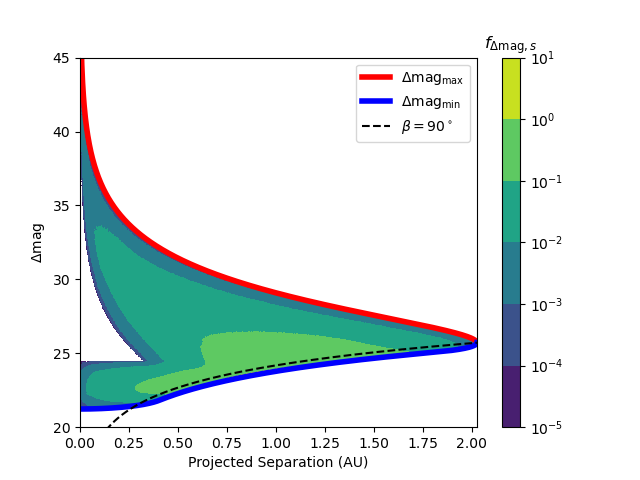

In [25]:
# set semi-major axis and eccentricity ranges:
arange, erange = [0.7, 1.5], [0, 0.35]
R_P = (1*u.earthRad).to(u.AU).value # Earth radius-equivalent planet in AU
p = 0.367 # geometric albedo
Cpdf, sax, dMagax = SSWYieldModelingTutorial.load_precomputed_completeness()
dmagmax, dmagmin, dmag90 = SSWYieldModelingTutorial.calc_Cpdf_limits(sax, arange, erange, p, R_P)
fig4, ax4 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax4.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax4.set_xlabel("Projected Separation (AU)")
ax4.set_ylabel("$\Delta$mag");
cbar = fig4.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");
ax4.plot(sax, dmagmax, "r", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{max}$")
ax4.plot(sax, dmagmin, "b", linewidth=4, label="$\\Delta\\mathrm{mag}_\\mathrm{min}$")
ax4.plot(sax, dmag90, "k--", label="$\\beta = 90^\\circ$")
ax4.legend()
ax4.set_ylim([20,45]);

We immediately see that with a full $10^9$ samples, we fully fill the space between our maximum and minimum bounding lines.  More importantly, there are no samples outside of these lines, proving that the bounds are correctly computed. Take a moment to study this plot.  This is often referred to as a 'bird plot' (after the shape), and was first published by Bob Brown in his 2005 paper (possibly the most important contribution to the field of exoplanet yield modeling).  The shape of the joint density function is entirely driven by the input parameters.  The divot on the left-hand side of the plot is due to our inclusion of a maximum eccentricity value (allowing eccentricities up to the upper bound of 1 would fill in the blank area present in the current plot).  Finally, we can confirm what we suspected from our previous iteration of this plot: the highest probability region of this density function lies along the bounding minimum $\Delta\mathrm{mag}$ curve.

# Completeness

We now have all of the building blocks we need in order to compute **completeness**: the probability of detecting a planet from a given population about a given target star with a given instrument, assuming that one is there.  Obviously, this is a whole lot of 'givens', but we've actually already established all of them.  Our assumed population of planets is fully encoded in the joint probability density function we evaluated in the previous section.  The instrument is encoded by the inner and outer working angles and the limiting $\Delta\mathrm{mag}$. Putting these two together, the completeness is then just the marginalization of the joint density function under the instrumental constraints:
$$ c = \int_{s_\textrm{min}}^{s_\textrm{max}} \int_0^{\Delta\mathrm{mag}_\mathrm{lim}} f_{\Delta\mathrm{mag},s} \, \mathrm{d}\Delta\mathrm{mag}\,\mathrm{d}s$$
where $s_\textrm{min},s_\textrm{max}$ are the minimum and maximum observable projected separation values, which, as previously discussed can be computed as IWA$d$ and OWA$d$, respectively, where $d$ is the distance to the target star in parsecs.

As we have computed our joint observable distribution as a discretized, normalized 2D histogram, we can implement the double integral in the equation above as a double summation (this is equivalent to implementing a Riemann sum):
$$ c \approx \sum_{s = s_\textrm{min}}^{s_\textrm{max}} \sum_{\Delta\mathrm{mag} = 0}^{\Delta\mathrm{mag}_\mathrm{lim}} C_\mathrm{pdf}(s, \Delta\mathrm{mag})$$

Essentially, we are carving out a rectangular area within our joint density function (under the assumption that the limiting $\Delta\mathrm{mag}$ is constant at all projected separations), and then summing the contents of our histogram within this box.  This looks something like:

In [ ]:
fig4, ax4 = plt.subplots()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = ax4.contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
ax4.set_xlabel("Projected Separation (AU)")
ax4.set_ylabel("$\Delta$mag");
cbar = fig4.colorbar(cs)
cbar.ax.set_title("$f_{\Delta\\mathrm{mag},s}$");
ylim = [20,45]
ax4.set_ylim(ylim);
projIWA = 0.075 # AU
projOWA = 1 # AU
ax4.plot([projIWA] * 2, [ylim[0], 25], "k--", label="Projected IWA")
ax4.plot([projOWA] * 2, [ylim[0], 25], "k-.", label="Projected OWA")
ax4.plot([projIWA, projOWA], [25] * 2, "k:", label="$\\Delta$mag=25")
ax4.legend();

One caveat here is that the grid that we computed the histogram over may be discretized too coarsely (that is, we may wish to pick limits that fall between grid entries).  We solve this by interpolating over the grid.

## Exercise 4

Let's try this out.  Write a function that, given the joint observable PDF and instrument limits, computes the completeness.

In [ ]:
def calc_completeness(Cpdf, sax, dMagax, smin, smax, dMaglim):
    """Compute the completeness of an observation

    Args:
        Cpdf (np.ndarray):
            2D, normalized, joint probability histogram of s and dMag
        sax (np.ndarray):
            Projected separation axis of Cpdf (AU)
        dMagax (np.ndarray):
            dMag axis of Cpdf
        smin (arraylike):
            Minimum observable projected separation (projected IWA) (AU)
        smax (arraylike):
            Maximum observable projected separation (projected OWA) (AU)
        dMaglim (arraylike):
            Maximum observable Delta mag value

    Returns:
        arraylike:
            Completeness values
            
    Notes:
        All arraylike inputs must have the same dimensionalities (or be scalars)

    """


    # Your code goes here
    # Hint 1: You may find the method scipy.interpolate.RectBivariateSpline useful here. See:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html
    #
    # Hint 2: The contents of Cpdf are probably transposed from what you might expect
    
    comp = 
    
    return comp

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_completeness

# when you're done, test your function:
calc_completeness(Cpdf, sax, dMagax, 0.075, 1, 25)
# the expected output is ~0.42

## The Impact of Stellar Distance
Now that we have the capability to compute completeness values, we can explore how they change with inputs.  We've already established that the minimum and maximum observable projected separations are linear functions of stellar distance.  Let's look at how the target star's distance impacts the completeness:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

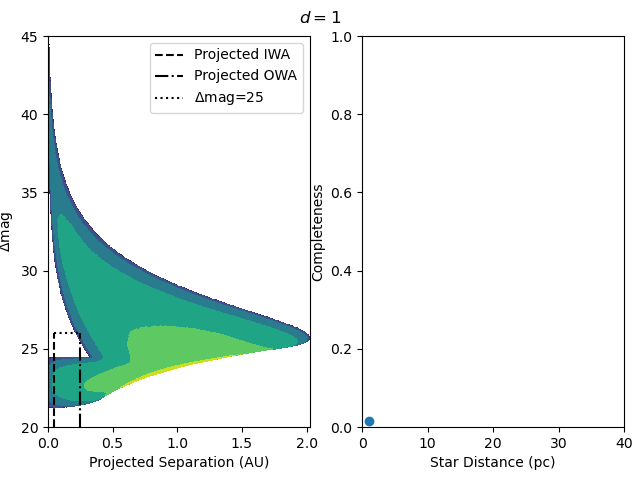

In [26]:
# We'll consider targets in the range of 1 to 41 parsecs
dists = np.arange(1, 41) # parsecs
IWA = 0.05 # arcseconds
OWA = 0.25 # arcseconds
smins = IWA*dists
smaxs = OWA*dists
dMaglim = 25
comps = SSWYieldModelingTutorial.calc_completeness(Cpdf, sax, dMagax, smins, smaxs, dMaglim)

ylim = [20,45]
fig5, axs5 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs5[0].contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
axs5[0].set_xlabel("Projected Separation (AU)")
axs5[0].set_ylabel("$\Delta$mag")
pIWA = axs5[0].plot([smins[0]] * 2, [ylim[0], dMaglim], "k--", label="Projected IWA")[0]
pOWA = axs5[0].plot([smaxs[0]] * 2, [ylim[0], dMaglim], "k-.", label="Projected OWA")[0]
dmaglim = axs5[0].plot(
    [smins[0], smaxs[0]], [25] * 2, "k:", label=f"$\\Delta$mag={dMaglim}"
)[0]
axs5[0].legend()
axs5[0].set_ylim(ylim)
xlim0 = axs5[0].get_xlim()
fig5.suptitle(f"$d = ${dists[0]}")

compline = axs5[1].plot(dists[0], comps[0])[0]
comppoint = axs5[1].scatter(dists[0], comps[0])
axs5[1].set_xlim([0, 40])
axs5[1].set_ylim([0, 1])
axs5[1].set_xlabel("Star Distance (pc)")
axs5[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)

def drawCompFrame(j):
    pIWA.set_data([smins[j]] * 2, [ylim[0], 26])
    pOWA.set_data([smaxs[j]] * 2, [ylim[0], 26])
    dmaglim.set_data([smins[j], smaxs[j]], [26] * 2)
    if smaxs[j] > sax.max():
        axs5[0].set_xlim([0, smaxs[j]])
    else:
        axs5[0].set_xlim(xlim0)
    fig5.suptitle(f"$d = ${dists[j]}")
    compline.set_data(dists[: j + 1], comps[: j + 1])
    comppoint.set_offsets((dists[j], comps[j]))
    
widgets.interact(drawCompFrame, j=widgets.IntSlider(min=0, max=len(dists)-1, step=1, value=0));
# use slider to change the star distance

We can see that the effect of moving to further and further targets: the observable box scales linearly outwards from the star, covering a different subsection of the joint density function for different stellar distances.  For the specific IWA/OWA values we have selected here, the bounding box covers the largest portion of the highest-probability portion of the distribution for a stellar distance of ~7 pc, leading to the highest completeness value at that distance.  

**Be very careful here**.  Note *all* of the assumptions that went into this result.  We had to both postulate the underlying planet population *and* the instrument's capabilities. Making changes to either would lead to a different result.

The second thing to note is that we only needed to compute the underlying density function once.  In order to get different completeness results for different observing cases, we only adjusted the limits of our integration (summation).  This will be a recurring theme as we study other effects.

## Habitable Zones and Stellar Luminosity

At first glance, our equations do not predict any changes in completeness with stellar luminosity, but this changes when you focus specifically on Earth-like planets.  While there is not broad consensus on what exactly makes a planet 'Earth-like', in general, you want these planets to receive about as much radiant flux from their host stars as the Earth receives from the sun. This means that we wish to match insolation distance rather than absolute distance between planet and star. That is, we want to scale our planets' semi-major axes as $a = \sqrt{L}a_{L=1 L_\odot}$ where $a_{L=1 L_\odot}$ is the semi-major axis at 1 solar luminosity. The full range of semi-major axes we wish to study is similarly scaled, leading to a very basic definition of the **habitable zone**. 

This semi-major axis scaling implies that the orbital radius similarly scales as $r = \sqrt{L}r_{L=1 L_\odot}$, meaning that so does the projected separation: $$s = \sqrt{L}s_{L=1 L_\odot}$$

If you plug these scalings into the $\Delta\mathrm{mag}$ expression, you find:
$$\Delta\mathrm{mag} = \Delta\mathrm{mag}_{L=1 L_\odot} + 2.5\log_{10}\left(L\right)$$

Note that there's no need to recompute our underlying joint probability density function for different values of stellar luminosity.  Instead, we only need to re-interpret the axes.  With the inclusion of stellar luminosity, we read the abscissa as $s/\sqrt{L}$ and the ordinate as $\Delta\mathrm{mag} - 2.5\log_{10}\left(L\right)$.

## Exercise 5

Let's try this out. Update your previous completeness calculation function, taking into account the stellar luminosity (under the assumption that we're matching stellar insolation for our planet population). 

In [ ]:
def calc_completeness(Cpdf, sax, dMagax, smin, smax, dMaglim, L):
    """Compute the completeness of an observation

    Args:
        Cpdf (np.ndarray):
            2D, normalized, joint probability histogram of s and dMag
        sax (np.ndarray):
            Projected separation axis of Cpdf (AU)
        dMagax (np.ndarray):
            dMag axis of Cpdf
        smin (arraylike):
            Minimum observable projected separation (projected IWA) (AU)
        smax (arraylike):
            Maximum observable projected separation (projected OWA) (AU)
        dMaglim (arraylike):
            Maximum observable Delta mag value
        L (arraylike):
            Stellar luminosity in solar luminosities

    Returns:
        arraylike:
            Completeness values
    
    Notes:
        All arraylike inputs must have the same dimensionalities (or be scalars)

    """


    # Your code goes here

    comp = 
    
    return comp

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_completeness

# when you're done, test your function:
calc_completeness(Cpdf, sax, dMagax, 0.075, 1, 25, 1.5)
# the expected output is ~0.258

## The Impact of Stellar Luminosity

We can now explore how changing the luminosity impacts completeness:

interactive(children=(IntSlider(value=0, description='j', max=39), Output()), _dom_classes=('widget-interact',…

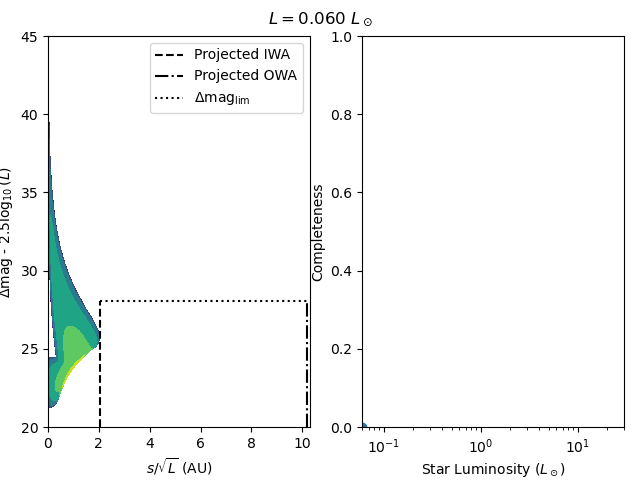

In [28]:
# assume a fixed star at 10 pc:
d = 10 # parsecs
IWA = 0.05 # arcseconds
OWA = 0.25 # arcseconds
smins = IWA*d
smaxs = OWA*d
dMaglim = 25

# generate a logarithmically spaced array of luminosities
Ls = np.logspace(np.log10(0.06), np.log10(30), 40)
comps2 = SSWYieldModelingTutorial.calc_completeness(Cpdf, sax, dMagax, smins, smaxs, dMaglim, Ls)

ylim = [20,45]
dmags2 = dMaglim - 2.5 * np.log10(Ls)
smins2 = smins/np.sqrt(Ls)
smaxs2 = smaxs/np.sqrt(Ls)
fig6, axs6 = plt.subplots(1, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cs = axs6[0].contourf(
        sax,
        dMagax,
        Cpdf,
        locator=ticker.LogLocator(),
    )
axs6[0].set_xlabel("$s/\sqrt{L}$ (AU)")
axs6[0].set_ylabel("$\Delta$mag - 2.5$\log_{10}(L)$")
pIWA2 = axs6[0].plot([smins2[0]] * 2, [ylim[0], dmags2[0]], "k--", label="Projected IWA")[0]
pOWA2 = axs6[0].plot([smaxs2[0]] * 2, [ylim[0], dmags2[0]], "k-.", label="Projected OWA")[0]
dmaglim2 = axs6[0].plot(
    [smins2[0], smaxs2[0]], [dmags2[0]] * 2, "k:", label="$\\Delta$mag$_\\mathrm{lim}$"
)[0]
axs6[0].legend(loc=1)
axs6[0].set_ylim(ylim)
fig6.suptitle(f"$L = ${Ls[0] :.3f} $L_\odot$")

compline2 = axs6[1].semilogx(Ls[0], comps2[0])[0]
comppoint2 = axs6[1].scatter(Ls[0], comps2[0])
axs6[1].set_xlim([np.min(Ls), np.max(Ls)])
axs6[1].set_ylim([0, 1])
axs6[1].set_xlabel("Star Luminosity ($L_\odot$)")
axs6[1].set_ylabel("Completeness")

plt.subplots_adjust(top=0.925, left=0.075, right=0.975)


def drawCompFrame2(j):
    pIWA2.set_data([smins2[j]] * 2, [ylim[0], dmags2[j]])
    pOWA2.set_data([smaxs2[j]] * 2, [ylim[0], dmags2[j]])
    dmaglim2.set_data([smins2[j], smaxs2[j]], [dmags2[j]] * 2)
    if smaxs2[j] > sax.max():
        axs6[0].set_xlim([0, np.ceil(smaxs2[j]*10)/10])
    else:
        axs6[0].set_xlim([0,sax.max()])
    fig6.suptitle(f"$L = ${Ls[j] :.3f} $L_\odot$")
    compline2.set_data(Ls[: j + 1], comps2[: j + 1])
    comppoint2.set_offsets((Ls[j], comps2[j]))

widgets.interact(drawCompFrame2, j=widgets.IntSlider(min=0, max=len(Ls)-1, step=1, value=0));
# use slider to change the star luminosity

Note that the effect of scaling stellar luminosity is a bit more complex than when changing the stellar distance, as the luminosity changes the bounds of the box we're integrating within in both dimensions. For low stellar luminosities, the habitable zone moves inwards, towards the star, making the requirements on IWA very challenging.  For a fixed IWA, as we're assuming here, eventually the full joint distribution moves outside of the bounding box (at somewhere around 0.06 solar luminosities). For the assumed fixed distance of 10 pc (and our IWA/OWA/limiting $\Delta\mathrm{mag}$) assumptions), we find a peak in the completeness at around 0.65 solar luminosities.  As we continue to increase the luminosity, the habitable zone keeps moving outwards (which makes for easier IWA requirements) but the planets also get fainter (due to the reciprocal orbital radius magnitude term in the $\Delta\mathrm{mag}$ equation), making instrumental limiting $\Delta\mathrm{mag}$ requirements more challenging. By the time we get to 30 solar luminosities (roughly an A1V star - think just a bit dimmer than Vega), the bounding box has fully moved *below* the joint density function and the completeness is once again zero.

Finally, always remember that both the luminosity scaling and stellar distance scaling effects are happening at the same time!

# Integration Time

You may have noticed a glaring gap in our formulation of how we compute completeness: it appears to be entirely independent of integration (or exposure) time.  This is decidedly non-physical, as, intuitively, we should be able to see fainter planets if we collect more photons.  In reality, the integration time folds into the determination of our limiting $\Delta\mathrm{mag}$.  In order to see how, we first need to define an integration time model. 

## Signal to Noise Ratio

We start by modeling the signal that we collect with our instrument as the sum of the photons from the thing we wish to measure (e.g., a planet, so we'll call this $c_p$) plus the photons from everything else (e.g., the background, so we'll call this $c_b$).  We can equivalently define the rates of photon arrival from each of these sources (which we'll represent with an overbar) such that our total measurement is:
$$z = \bar{c}_pt_\mathrm{int} +  \bar{c}_bt_\mathrm{int}$$

We ultimately wish to make a statistical statement about what we thought we detected, which is typically encoded as a **signal to noise** (SNR) metric (or ratio).  SNR actually has *a lot* of formal definitions, which vary by field and application area, but the one most useful in our case is the ratio of the expectation value of the signal (the thing we wish to measure) to the standard deviation of the noise (everything else).  Photon arrival is a Poisson process&mdash;that is, the distribution of photons collected in a given span of time is governed by a Poisson distribution, which describes the probability of recording a certain number of events per unit time when the events have a constant rate of occurrence. One nice attribute of a Poisson distribution is that its standard deviation is equal to the square root of its mean value. 

So, under all these assumptions, our SNR metric is defined as:
$$\mathrm{SNR} = \frac{\bar{c}_pt_\mathrm{int}}{\sqrt{ \bar{c}_pt_\mathrm{int}  + \bar{c}_bt_\mathrm{int} }} = \frac{\bar{c}_p}{\sqrt{ \bar{c}_p  + \bar{c}_b }} \sqrt{t_\mathrm{int}}$$

Note that the denominator (the noise term) includes both the planet and background counts.  This is because Poisson noise (sometimes called **shot noise**) is generated by *all* incoming photons.  One immediate observation is that our SNR goes as the square root of integration time. So, if you want to double your SNR, you need to quadruple how long you collect photons for. The other thing to note is that this expression appears to predict that you can get to an arbitrarily high SNR if you are willing to integrate for an arbitrary long time.  This latter assertion is problematic because it is inherently non-physical for every optical system built to date.  In general, there will always be some **noise floor** (typically linked to the inherent stability of the optical system) that means that at a certain integration time, you stop gaining any SNR. Detailed modeling of such a noise floor can be arbitrarily complex, so instead, we will provide ourselves with a simplified model of the form:
$$\mathrm{SNR} = \frac{\bar{c}_pt_\mathrm{int}}{\sqrt{ \bar{c}_pt_\mathrm{int}  + \bar{c}_bt_\mathrm{int} + (Mt_\mathrm{int})^2) }}$$
where $M$ is a term inherently capturing our system's noise floor.  As $Mt_\mathrm{int}$ is added to our noise term in quadrature, $M$ can be interpreted as the photon rate associated with the standard deviation of a noise component that fundamentally cannot be subtracted out from our measured signal. 

Using these definitions, we can now invert the expression to compute integration times as:
$$t_\mathrm{int} = \frac{ \bar{c}_p + \bar{c}_b }{\left(\dfrac{\bar{c}_p}{\mathrm{SNR}}\right)^2 - M^2}$$
which imposes the condition:
$$M < \frac{ \bar{c}_p}{\mathrm{SNR}}$$
These last two expressions fundamentally express the idea that for a given optical system and planet and noise count rates, there will be signal to noise ratios that are fundamentally unachievable (which matches our actual experience in real life). 

## Exercise 6

Write a function to compute integration times given input values of $ \bar{c}_p, \bar{c}_b$, $M$ and the required SNR. 

In [ ]:
def calc_intTime(Cp, Cb, M, SNR):
    """Find the integration time to reach a required SNR given the planet and
    background count rates as well as the optical system's noise floor.


    Args:
        Cp (arraylike Quantity):
            Planet count rate (1/time units)
        Cb (arraylike Quantity):
            Background count rate (1/time units)
        M (arraylike Quantity):
            Noise floor count rate (1/time units)
        SNR (float):
            Required signal to noise ratio

    Returns:
        ~astropy.units.Quantity(~numpy.ndarray(float)):
            Integration times

    .. note::

        All infeasible integration times should be returned as NaN values

    """

    # your code goes here:
    intTime = 


    # infinite and negative values are set to NAN
    intTime[np.isinf(intTime) | (intTime.value < 0.0)] = np.nan

    return intTime

# if you get stuck: a reference implementation is available in SSWYieldModelingTutorial.calc_intTime

# when you're done, test your function:
Cp = 0.03/u.s # planet count rate photons/second (photons excluded from unit)
Cb = 0.01/u.s # background count rate photons/second (photons excluded from unit)
M = 0.003/u.s # noise floor count rate photons/second (photons excluded from unit)
SNR = 5
calc_intTime(Cp, Cb, M, SNR)
# the expected output is ~1481 seconds

## Modeling Planet and Background Counts

Now that we have our SNR and integration time equations, we need to be able to model the individual terms involved, and map them to the quantities that determine completeness. We'll start with the planet count rate.

### Planet Count Rate
Remember that the $\Delta\mathrm{mag}$ encodes the flux ratio of the planet to its host star. Therefore, we can express the spectral flux density (or irradiance) of a planet as $C_\mathrm{star} 10^{-0.4\Delta\mathrm{mag}}$ where $C_\mathrm{star}$ is the spectral flux density of the star, and -0.4 is the reciprocal of -2.5. We can further define:
$$C_\mathrm{star} = \mathcal{F}_0 10^{-0.4\mathrm{mag}_\mathrm{star}}$$
where $\mathcal{F}_0$ is the spectral flux density (in your observing wavelength band) of a zero-magnitude star, and $\mathrm{mag}_\mathrm{star}$ is the apparent magnitude of your target star in that same band.

We've now defined the spectral flux density of the planet, but we actually care about the planet count rates recorded on our instrument's detector.  Recall that spectral flux density is energy per time per area per wavelength (thanks to the Planck constant, equivalently photons per time per area per wavelength). In order to compute the planet count rate, we need to scale the spectral flux density by our telescope's collecting area, the wavelength range of our observing band (the bandpass), and any losses due to the optical system.  So, we define:
$$\bar{c}_p =  \mathcal{F}_0 10^{-0.4(\mathrm{mag}_\mathrm{star}+ \Delta\mathrm{mag})}A \Delta\lambda \tau \tau_\mathrm{core} \mathrm{QE}$$
where $\Delta\lambda$ is the bandpass of our observing band, $\tau$ is the throughput of our system due to everything *other* than whatever technology is used to suppress the star's light (that is, all losses due to internal reflections and transmissions), and $\tau_\mathrm{core}$ is the throughput of our starlight suppression technology for point sources. $A$ is the effective collecting area of our telescope (e.g. the primary mirror area minus the area of any obscuration), which we compute (for a circular aperture of diameter $D$ and obscuration factor $f_\mathrm{obsc}$) as:
$$A = \pi \left(\frac{D}{2}\right)^2(1 - f_\mathrm{obsc})\,.$$
Finally QE is the quantum efficiency of our detector: this is the mean rate at which photons are converted to electrons (which is what ultimately gets measured and recorded). If you're keeping track of units, the application of the QE factor transforms any units of photons to units of electrons.  In real detectors, there's some additional complexity in the digitization of the electron counts to actual recorded counts (typically represented as digital numbers or DN units), but for simplicity we will assume that one electron produces on recorded count value.

### Astrophysical Background Count Rates
The background signal will include counts from astrophysical sources as well as noise from the instrument itself.  The most important astrophysical background sources are the local zodiacal light ($\bar{c}_\mathrm{zodi}$; light reflected form the dust cloud shrouding the inner solar system), exozodiacal light ($\bar{c}_\mathrm{exozodi}$; light reflected from similar dust clouds in the target exosystem), and residual starlight not blocked by our starlight suppression technology ($\bar{c}_{sr}$). We model the local zodiacal light contribution as:
$$\bar{c}_\mathrm{zodi} = \mathcal{F}_0 10^{-0.4z} \Omega A \Delta\lambda \tau \tau_\mathrm{occ} \mathrm{QE}$$
where $\tau_\mathrm{occ}$ is the throughput of our starlight suppression technology for infinitely extended sources, $z$ is the surface brightness of the local zodi in units of magnitudes per unit solid angle (nominally 23 mag arcsec$^{-2}$), and $\Omega$ is the solid angle of our photometric aperture. We will assume that our instrument is critically sampled at the central wavelength of our bandpass ($\lambda$) then we can compute the photometric aperture solid angle as:
$$\Omega = \pi\left(\frac{\lambda}{2D}\right)^2 \,.$$
Note that the unit of this value (if the wavelength and primary diameter have the same length unit) is a steradian (radian^2).  To make this work with the previous expression, we need to convert this to square arcseconds.

The exozodi contribution is computed in the exact same way, except that we replace the value of $z$ with whatever we are assuming for the brightness of the exozodi (at this point, we literally don't know what this should be - we haven't built instruments sensitive enough to directly measure this yet).

In [4]:
static_params = {"lam": 550*u.nm, # 550 nm central wavelength
                 "deltaLam": 110*u.nm, # 20% bandpass
                 "D": 6*u.m, # 6 meter telescope
                 "obsc": 0.1, # Primary is 10% obscured
                 "tau": 0.5, # The non-coronagraphic throughput
                 "QE": 0.9, # 90% Quantum Efficiency
                 # Zero-mag flux in photons cm^-2 nm^-1 s^-1 (photons omitted from unit):
                 "F0": 12000/u.cm**2/u.nm/u.s, 
                }

coronagraph = {"tau_core": 0.1, # point source throughput 
               "tau_occ": 0.2,  # extended source throughput
              }


target = {"mag_star": 5, # apparent magnitude
          "deltaMag": 25, # mag_planet - mag_star
          "zodi": 23, # local zodi (units omitted as we're using this as an exponent)     
          "exozodi": 22, # exozodi (assume a bit brighter than local zodi)
         }